In [1]:
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")
import pandas as pd
import numpy as np
import warnings
import mlflow
from modeling.config import TRACKING_URI, EXPERIMENT_NAME
from pandas_profiling import ProfileReport
import pyarrow.feather as feather
import time
from datetime import datetime


In [2]:
export_df = feather.read_feather("../data/cleaned_data.feather")

In [3]:
export_df["event_timestamp"]=pd.to_datetime(export_df["event_timestamp"]*1000, unit="ns")

In [4]:
export_df["notif_viewed_ontime"]=list(map(lambda x,y,z: np.nan if x=="notification_received" else (1 if y < z else 0), export_df["event_name"], export_df["event_timestamp"],export_df["closed_at"])) #1 if the user view it on time  0 if not  and null if hasnt yet seen it 


In [24]:
export_df['user_id'].nunique()

13263

In [5]:

export_df.dropna ( subset=['notif_viewed_ontime'], inplace=True)
export_df.reset_index(drop=True, inplace=True)
export_df["notif_viewed_ontime"]=export_df["notif_viewed_ontime"].astype(int)

In [6]:
export_df["reaction_time"]=list(map(lambda x,y,z,w: y-z
if (x==1 and y>z) else (y-w if (x==1 and y>w) else 0), 
export_df["notif_viewed_ontime"],export_df["event_timestamp"],export_df["published_at"],export_df["created_at"]))

In [7]:
active_df=export_df
#active_df=export_df[export_df["notif_viewed_ontime"]==1].reset_index(drop=True)
#unactive_df=export_df[export_df["notif_viewed_ontime"]==0].reset_index(drop=True)
#active_df.drop('notif_viewed_ontime', axis=1, inplace=True)
#unactive_df.drop('notif_viewed_ontime', axis=1, inplace=True)
#pd.set_option('display.max_columns', None)
active_df


,event_timestamp,event_name,user_id,document_id,surrogate_id,created_at,published_at,closed_at,cause,effect,...,agency_JUR9bFXmVkWDHqu4AXaY0g,agency_JfA8Bw8Zp024Kqu4AXiSpQ,agency_MgUq5b9mOEunx6u4AXt_BA,agency_NuuRQ2I1Q0a50Kv-AVKlLA,agency_V2AIQQKgmUO3VazvAOA-Cw,agency_jLjibFoim0iwWau4AWoEdQ,agency_pky7jovXYkaw-awAAMrQ3g,agency_zCy9zG00HEqGeKu4AWZYNQ,notif_viewed_ontime,reaction_time
0,2021-05-28 22:29:19.952000,notification_dismiss,ac6d3,-Map3NyDNGaNwnfF6F0B,4Np4EQPA6xGpKOFIXMTiIg,2021-05-28 22:21:37,2021-05-28 22:21:44,2021-05-28 23:01:00,VehicularAccident,Delays,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0 days 00:07:35.952000
1,2021-05-29 00:36:08.285001,notification_dismiss,ac6d3,-MapQ4JNaTLEWbF2EG-b,kGA96xDA6xGpKOFIXMTiIg,2021-05-29 00:00:46,2021-05-29 00:21:36,2021-05-29 01:01:00,VehicularAccident,Delays,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0 days 00:14:32.285001
2,2021-05-29 03:15:29.077003,notification_dismiss,ac6d3,-Maq6YwIAylgKasYIYqR,MBYBESzA6xGpKOFIXMTiIg,2021-05-29 03:15:06,2021-05-29 03:15:43,2021-05-29 04:01:00,Waterlogging,TrafficImpact,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0 days 00:00:23.077003
3,2021-05-29 03:15:34.229004,notification_dismiss,ac6d3,-Maq63vqDUxQRawQ_3Au,YKlNxSvA6xGpKOFIXMTiIg,2021-05-29 03:12:59,2021-05-29 03:15:13,2021-05-29 13:59:03,Demonstration,CirculationShutdown,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0 days 00:00:21.229004
4,2021-05-29 03:17:52.571006,notification_dismiss,ac6d3,-Maq7-D7bhcEaFBU1LDW,gDALVizA6xGpKOFIXMTiIg,2021-05-29 03:17:01,2021-05-29 03:17:12,2021-05-29 04:01:00,Incident,Delays,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0 days 00:00:40.571006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908718,2021-07-06 12:58:14.459002,notification_opened,0b751,-MdvtGBpZP2CU9bByS9K,UIa_t1ne6xGAO2PVuXEkFw,2021-07-06 12:57:28,2021-07-06 12:57:31,2021-07-06 15:00:15,Incident,Delays,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0 days 00:00:43.459002
908719,2021-07-06 15:21:54.555002,notification_opened,15e79,-MdwPCoa1U3j5wMZ8J99,YNy_023e6xGa3QeEZ-Zg-g,2021-07-06 15:21:25,2021-07-06 15:21:36,2021-07-06 20:46:48,Demonstration,SuspensionOfService,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0 days 00:00:18.555002
908720,2021-07-06 00:35:42.674000,notification_opened,bfd2d,-MdtE7Z7C65hUvaiOMpt,gAgq4PHd6xGf17VsriRlgg,2021-07-06 00:34:08,2021-07-06 00:34:17,2021-07-06 02:00:01,Flood,Delays,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0 days 00:01:25.674000
908721,2021-07-06 12:28:27.916002,notification_opened,bfd2d,-MdvKCnIXRL8TLX0fzWw,MDJztkPe6xGEdyPHk--PKA,2021-07-06 10:19:57,2021-07-06 10:20:24,2021-07-06 13:00:00,Overturn,CirculationShutdown,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0 days 02:08:03.916002


In [39]:
active_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908723 entries, 0 to 908722
Data columns (total 27 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   event_timestamp                       908723 non-null  datetime64[ns]
 1   event_name                            908723 non-null  object        
 2   user_id                               908723 non-null  object        
 3   document_id                           908723 non-null  object        
 4   surrogate_id                          908723 non-null  object        
 5   created_at                            908723 non-null  datetime64[ns]
 6   published_at                          908723 non-null  datetime64[ns]
 7   closed_at                             908060 non-null  datetime64[ns]
 8   cause                                 908723 non-null  object        
 9   effect                                908723 non-null  obje

In [9]:
active_df.loc[active_df['event_name'].isin(['notification_opened', 'notification_view_alternatives' ,  'notification_share']),'opened']= 1
active_df.loc[active_df['event_name'].isin(['notification_received', 'notification_dismiss']),'opened']= 0
active_df['opened']=active_df['opened'].astype(int)


In [10]:
active_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908723 entries, 0 to 908722
Data columns (total 27 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   event_timestamp                       908723 non-null  datetime64[ns]
 1   event_name                            908723 non-null  object        
 2   user_id                               908723 non-null  object        
 3   document_id                           908723 non-null  object        
 4   surrogate_id                          908723 non-null  object        
 5   created_at                            908723 non-null  datetime64[ns]
 6   published_at                          908723 non-null  datetime64[ns]
 7   closed_at                             908060 non-null  datetime64[ns]
 8   cause                                 908723 non-null  object        
 9   effect                                908723 non-null  obje

In [11]:
gpbyincident= active_df.groupby( by= ['document_id', 'description','cause', 'effect'])
gpbyincident2=gpbyincident.sum()
gpbyincident2['count'] = gpbyincident.size()
gpbyincident2['opened_rate'] = gpbyincident2['opened']/gpbyincident2['count']
gpbyincident2['ontime_activity_rate'] = gpbyincident2["notif_viewed_ontime"]/gpbyincident2['count']
gpbyincident2



,,,,area_of_effect_coordinates_latitude,area_of_effect_coordinates_longitude,agency_GewRJAw5tUmC4Ku4AX1-SQ,agency_GtvOEQAFZ0GtU6u4AXwvPg,agency_HE59N3RXM0q5vKu4AXlQZg,agency_JUR9bFXmVkWDHqu4AXaY0g,agency_JfA8Bw8Zp024Kqu4AXiSpQ,agency_MgUq5b9mOEunx6u4AXt_BA,agency_NuuRQ2I1Q0a50Kv-AVKlLA,agency_V2AIQQKgmUO3VazvAOA-Cw,agency_jLjibFoim0iwWau4AWoEdQ,agency_pky7jovXYkaw-awAAMrQ3g,agency_zCy9zG00HEqGeKu4AWZYNQ,notif_viewed_ontime,opened,count,opened_rate,ontime_activity_rate
document_id,description,cause,effect,,,,,,,,,,,,,,,,,,
-MPvKI-ULauyGmrJiWwV,⏳ ¡Ojo! Retrasos por movilización de cuerpos de emergencia en Calzada México-Tacuba cerca del Metro Cuitláhuac.,EmergencyServices,Delays,-495.908793,97.287246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2,0,5,0.000000,0.400000
-MPvhmTRVhrMWLAjtSS6,⏳ ¡Toma tus precauciones! Retrasos por incendio en Av. del Mazo y Norte 23.,Fire,Delays,-197.878559,38.598469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,0,2,0.000000,0.000000
-MPvo6hGxeJyKSVcnAUl,✋ ¡Chanclas! Retrasos por accidente sobre Calzada Ignacio Zaragoza cerca del Metro Peñón Viejo hacia la Concordia.,VehicularAccident,Delays,-297.053541,58.121099,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3,0,3,0.000000,1.000000
-MPwL4RRplvymPwZRy2F,⏳ ¡Aguas! Retrasos por percance vehicular en Calz. Ignacio Zaragoza y Río Churubusco.,VehicularAccident,Delays,-891.689990,174.673242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,5,0,9,0.000000,0.555556
-MQCQhzkbRqMo0TsIibZ,"⏳ ¡Aguas! Retrasos por percance vehicular Avenida Cuauhtémoc a la altura de Obrero Mundial, en dirección a Xola.\n\n\n",VehicularAccident,LaneReduction,-30639.030107,5995.289716,0.0,0.0,0.0,309.0,309.0,0.0,0.0,0.0,0.0,0.0,0.0,50,32,309,0.103560,0.161812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-MdyS-3Odath0RqKOve5,⏳ ¡Ojo! Retrasos por percance en Av. Montevideo y Cienfuegos.,VehicularAccident,Delays,-9516.668998,1871.051321,0.0,0.0,0.0,0.0,96.0,0.0,0.0,0.0,0.0,0.0,0.0,57,3,96,0.031250,0.593750
-MdySISY5hSJPgekQ7pR,🚦 ¡Anticípate! Retrasos por semáforos descompuestos en Eje 6 Sur al cruce con Avenida Presidente Plutarco Elías Calles.,BrokenTrafficLight,Delays,-4163.695865,813.848794,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,31,0,42,0.000000,0.738095
-MdyjLp8Li6p6HZRc_So,⏳ ¡Úchala! Retrasos por percance en Calzada Ignacio Zaragoza a la altura de Avenida República Federal del Sur con dirección hacia Guelatao.,VehicularAccident,Delays,-13268.242253,2595.954543,0.0,134.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,134.0,94,4,134,0.029851,0.701493


In [12]:
gpbyincident2.describe()

,area_of_effect_coordinates_latitude,area_of_effect_coordinates_longitude,agency_GewRJAw5tUmC4Ku4AX1-SQ,agency_GtvOEQAFZ0GtU6u4AXwvPg,agency_HE59N3RXM0q5vKu4AXlQZg,agency_JUR9bFXmVkWDHqu4AXaY0g,agency_JfA8Bw8Zp024Kqu4AXiSpQ,agency_MgUq5b9mOEunx6u4AXt_BA,agency_NuuRQ2I1Q0a50Kv-AVKlLA,agency_V2AIQQKgmUO3VazvAOA-Cw,agency_jLjibFoim0iwWau4AWoEdQ,agency_pky7jovXYkaw-awAAMrQ3g,agency_zCy9zG00HEqGeKu4AWZYNQ,notif_viewed_ontime,opened,count,opened_rate,ontime_activity_rate
count,8420.000000,8420.000000,8420.000000,8420.000000,8420.000000,8420.000000,8420.000000,8420.0,8420.000000,8420.0,8420.000000,8420.000000,8420.000000,8420.000000,8420.000000,8420.000000,8420.000000,8420.000000
mean,-6879.182178,1347.125563,0.876603,48.321734,1.358789,32.474584,19.173040,0.0,3.948337,0.0,0.049406,0.120309,65.397268,62.587173,4.031948,107.924347,0.034943,0.576313
std,7671.179294,1502.351426,13.866641,72.531179,11.296999,124.775133,65.111682,0.0,28.118711,0.0,2.735292,3.576213,74.901521,86.357271,6.678048,128.588720,0.051803,0.221948
min,-89227.001397,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,-10005.587876,233.341796,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,8.000000,16.000000,0.000000,32.000000,0.000000,0.442289
50%,-4655.827140,908.578058,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,44.000000,36.000000,2.000000,69.000000,0.026316,0.575551
75%,-1190.122107,1956.086783,0.000000,77.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,96.000000,75.000000,5.000000,137.000000,0.047368,0.703834
max,0.000000,17489.552030,611.000000,866.000000,302.000000,1546.000000,866.000000,0.0,900.000000,0.0,223.000000,174.000000,900.000000,1246.000000,90.000000,1546.000000,1.000000,1.000000


In [13]:
gpbycause= active_df.groupby( by= ['cause'])
gpbycause2=gpbycause.sum()
gpbycause2['count'] = gpbycause.size()
gpbycause2['opened_rate'] = gpbycause2['opened']/gpbycause2['count']
gpbycause2['ontime_activity_rate'] = gpbycause2["notif_viewed_ontime"]/gpbycause2['count']
gpbycause2


,area_of_effect_coordinates_latitude,area_of_effect_coordinates_longitude,agency_GewRJAw5tUmC4Ku4AX1-SQ,agency_GtvOEQAFZ0GtU6u4AXwvPg,agency_HE59N3RXM0q5vKu4AXlQZg,agency_JUR9bFXmVkWDHqu4AXaY0g,agency_JfA8Bw8Zp024Kqu4AXiSpQ,agency_MgUq5b9mOEunx6u4AXt_BA,agency_NuuRQ2I1Q0a50Kv-AVKlLA,agency_V2AIQQKgmUO3VazvAOA-Cw,agency_jLjibFoim0iwWau4AWoEdQ,agency_pky7jovXYkaw-awAAMrQ3g,agency_zCy9zG00HEqGeKu4AWZYNQ,notif_viewed_ontime,opened,count,opened_rate,ontime_activity_rate
cause,,,,,,,,,,,,,,,,,,
BrokenTrafficLight,-1.641726e+05,3.216694e+04,0.0,910.0,61.0,0.0,650.0,0.0,307.0,0.0,0.0,0.0,1640.0,961,46,1656,0.027778,0.580314
BrokenVehicle,-2.683107e+06,5.253901e+05,677.0,23453.0,15.0,0.0,2684.0,0.0,285.0,0.0,0.0,16.0,26960.0,14760,750,28834,0.026011,0.511896
COVID19,-2.191931e+04,4.290266e+03,0.0,8.0,0.0,3489.0,104.0,0.0,0.0,0.0,0.0,0.0,150.0,3039,226,3751,0.060251,0.810184
Counterflow,0.000000e+00,0.000000e+00,0.0,0.0,0.0,304.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121,15,304,0.049342,0.398026
CycleRide,-9.281917e+04,1.816752e+04,0.0,860.0,0.0,0.0,426.0,0.0,137.0,0.0,0.0,0.0,936.0,516,18,936,0.019231,0.551282
Demonstration,-1.264902e+07,2.477000e+06,1995.0,82361.0,2716.0,7285.0,93394.0,0.0,15392.0,0.0,279.0,331.0,115550.0,114164,7276,176135,0.041309,0.648162
EmergencyServices,-5.523163e+06,1.081491e+06,151.0,42394.0,166.0,428.0,3756.0,0.0,852.0,0.0,0.0,107.0,54303.0,27578,1525,55935,0.027264,0.493037
Event,-2.072238e+04,4.062324e+03,0.0,77.0,0.0,895.0,239.0,0.0,0.0,0.0,0.0,0.0,209.0,965,88,1223,0.071954,0.789043
Explosion,-1.980777e+03,3.900331e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,14,3,20,0.150000,0.700000


In [14]:
gpbyincident2.describe()

,area_of_effect_coordinates_latitude,area_of_effect_coordinates_longitude,agency_GewRJAw5tUmC4Ku4AX1-SQ,agency_GtvOEQAFZ0GtU6u4AXwvPg,agency_HE59N3RXM0q5vKu4AXlQZg,agency_JUR9bFXmVkWDHqu4AXaY0g,agency_JfA8Bw8Zp024Kqu4AXiSpQ,agency_MgUq5b9mOEunx6u4AXt_BA,agency_NuuRQ2I1Q0a50Kv-AVKlLA,agency_V2AIQQKgmUO3VazvAOA-Cw,agency_jLjibFoim0iwWau4AWoEdQ,agency_pky7jovXYkaw-awAAMrQ3g,agency_zCy9zG00HEqGeKu4AWZYNQ,notif_viewed_ontime,opened,count,opened_rate,ontime_activity_rate
count,8420.000000,8420.000000,8420.000000,8420.000000,8420.000000,8420.000000,8420.000000,8420.0,8420.000000,8420.0,8420.000000,8420.000000,8420.000000,8420.000000,8420.000000,8420.000000,8420.000000,8420.000000
mean,-6879.182178,1347.125563,0.876603,48.321734,1.358789,32.474584,19.173040,0.0,3.948337,0.0,0.049406,0.120309,65.397268,62.587173,4.031948,107.924347,0.034943,0.576313
std,7671.179294,1502.351426,13.866641,72.531179,11.296999,124.775133,65.111682,0.0,28.118711,0.0,2.735292,3.576213,74.901521,86.357271,6.678048,128.588720,0.051803,0.221948
min,-89227.001397,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,-10005.587876,233.341796,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,8.000000,16.000000,0.000000,32.000000,0.000000,0.442289
50%,-4655.827140,908.578058,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,44.000000,36.000000,2.000000,69.000000,0.026316,0.575551
75%,-1190.122107,1956.086783,0.000000,77.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,96.000000,75.000000,5.000000,137.000000,0.047368,0.703834
max,0.000000,17489.552030,611.000000,866.000000,302.000000,1546.000000,866.000000,0.0,900.000000,0.0,223.000000,174.000000,900.000000,1246.000000,90.000000,1546.000000,1.000000,1.000000


In [15]:
gpbyuser= active_df.groupby( by= ['user_id'])
gpbyuser2=gpbyuser.sum()
gpbyuser2['count'] = gpbyuser.size()
gpbyuser2['opened_rate'] = gpbyuser2['opened']/gpbyuser2['count']
gpbyuser2['ontime_activity_rate'] = gpbyuser2["notif_viewed_ontime"]/gpbyuser2['count']
gpbyuser2

,area_of_effect_coordinates_latitude,area_of_effect_coordinates_longitude,agency_GewRJAw5tUmC4Ku4AX1-SQ,agency_GtvOEQAFZ0GtU6u4AXwvPg,agency_HE59N3RXM0q5vKu4AXlQZg,agency_JUR9bFXmVkWDHqu4AXaY0g,agency_JfA8Bw8Zp024Kqu4AXiSpQ,agency_MgUq5b9mOEunx6u4AXt_BA,agency_NuuRQ2I1Q0a50Kv-AVKlLA,agency_V2AIQQKgmUO3VazvAOA-Cw,agency_jLjibFoim0iwWau4AWoEdQ,agency_pky7jovXYkaw-awAAMrQ3g,agency_zCy9zG00HEqGeKu4AWZYNQ,notif_viewed_ontime,opened,count,opened_rate,ontime_activity_rate
user_id,,,,,,,,,,,,,,,,,,
00087,-1684.767232,330.804900,0.0,8.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,17.0,14,0,17,0.000000,0.823529
00117,0.000000,0.000000,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0,4,0.000000,0.750000
001e1,-1686.475347,328.643503,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,16,0,17,0.000000,0.941176
00205,-1784.841298,349.420908,0.0,18.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,18.0,1,6,18,0.333333,0.055556
0026c,-1586.079503,311.013728,0.0,11.0,0.0,8.0,2.0,0.0,2.0,0.0,0.0,0.0,16.0,2,2,24,0.083333,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff2a,-17638.600783,3458.458357,0.0,144.0,0.0,136.0,3.0,0.0,19.0,0.0,0.0,0.0,176.0,248,0,302,0.000000,0.821192
fff48,-3766.492158,736.428435,5.0,27.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,38.0,23,1,41,0.024390,0.560976
fff4d,0.000000,0.000000,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,2,8,0.250000,0.500000


In [16]:
export_df[export_df['user_id']=='00205']

,event_timestamp,event_name,user_id,document_id,surrogate_id,created_at,published_at,closed_at,cause,effect,...,agency_JfA8Bw8Zp024Kqu4AXiSpQ,agency_MgUq5b9mOEunx6u4AXt_BA,agency_NuuRQ2I1Q0a50Kv-AVKlLA,agency_V2AIQQKgmUO3VazvAOA-Cw,agency_jLjibFoim0iwWau4AWoEdQ,agency_pky7jovXYkaw-awAAMrQ3g,agency_zCy9zG00HEqGeKu4AWZYNQ,notif_viewed_ontime,reaction_time,opened
18629,2021-04-07 19:36:56.828000,notification_dismiss,00205,-MXX87zlR3noq1mtOqaq,EPa3xw-W6xGwsuNVj06Kow,2021-04-05 13:06:48,2021-04-05 13:10:23,2021-04-05 13:31:01,BrokenVehicle,Delays,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0
113417,2021-05-28 19:49:41.720000,notification_dismiss,00205,-MajoC7zpfk5A1xz-7pV,8PyV4DW_6xG4Qbcp98gfkQ,2021-05-27 21:52:48,2021-05-27 21:53:17,2021-05-27 22:49:01,Incident,Delays,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0
113418,2021-05-28 19:49:56.030000,notification_dismiss,00205,-MafXmT1SSXJt_8hzz9Z,MK04_46-6xGi7llQq_djFw,2021-05-27 01:58:14,2021-05-27 01:58:20,2021-05-27 02:23:00,Demonstration,CirculationRestored,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0
199940,2021-05-18 21:14:20.173000,notification_dismiss,00205,-M_wjSisU3wZxHEfulUP,gAPYy2q36xGcDHWUthA4bg,2021-05-17 23:51:27,2021-05-17 23:52:33,2021-05-18 00:51:00,VehicularAccident,Delays,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0
199941,2021-05-18 21:14:23.037001,notification_dismiss,00205,-M_x_zMwwgB8UQ8mYsJy,wAN6E4y36xGLqw8mITulug,2021-05-18 03:49:41,2021-05-18 03:50:00,2021-05-18 10:01:01,StreetWorks,CirculationShutdown,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0
245436,2021-05-16 04:55:35.606000,notification_dismiss,00205,-M_hC7-OBTcHj5f1JDky,kBBN5gu16xGS93PW5T0nmQ,2021-05-14 23:27:07,2021-05-14 23:28:22,2021-05-14 23:51:27,BrokenVehicle,CirculationShutdown,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0
420848,2021-02-23 14:36:07.713002,notification_opened,00205,-MUE7of2YiWk9Nfst6vH,MKEZZt116xGOuPtEmIznNg,2021-02-23 13:45:32,2021-02-23 13:52:26,2021-02-23 14:15:00,VehicularAccident,TrafficImpact,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,1
515752,2021-05-07 13:40:59.847000,notification_dismiss,00205,-M_3fwRW3izQqe3EQ8-M,ELnTJd2u6xGYDY8IXXysdA,2021-05-07 02:37:21,2021-05-07 02:39:54,2021-05-07 03:31:01,VehicularAccident,Delays,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0
515753,2021-05-07 13:41:02.096001,notification_dismiss,00205,-M_2DyeOWyfjnTTde-un,kDj9Z6Su6xGNPhm2SVXXLA,2021-05-06 19:51:10,2021-05-06 19:56:31,2021-05-06 21:03:16,VehicularAccident,Delays,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0
520168,2021-03-29 13:08:35.632002,notification_opened,00205,-MWxo1AQ2wPF0EBJpfx1,sMrSpYSQ6xG-ERtaYTaRHg,2021-03-29 11:48:15,2021-03-29 11:48:20,2021-03-29 12:03:00,VehicularAccident,LaneReduction,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,1


In [17]:
gpbyuser2.describe()

,area_of_effect_coordinates_latitude,area_of_effect_coordinates_longitude,agency_GewRJAw5tUmC4Ku4AX1-SQ,agency_GtvOEQAFZ0GtU6u4AXwvPg,agency_HE59N3RXM0q5vKu4AXlQZg,agency_JUR9bFXmVkWDHqu4AXaY0g,agency_JfA8Bw8Zp024Kqu4AXiSpQ,agency_MgUq5b9mOEunx6u4AXt_BA,agency_NuuRQ2I1Q0a50Kv-AVKlLA,agency_V2AIQQKgmUO3VazvAOA-Cw,agency_jLjibFoim0iwWau4AWoEdQ,agency_pky7jovXYkaw-awAAMrQ3g,agency_zCy9zG00HEqGeKu4AWZYNQ,notif_viewed_ontime,opened,count,opened_rate,ontime_activity_rate
count,13263.000000,13263.000000,13263.000000,13263.000000,13263.000000,13263.000000,13263.000000,13263.0,13263.000000,13263.0,13263.000000,13263.000000,13263.000000,13263.000000,13263.000000,13263.000000,13263.000000,13263.000000
mean,-4367.240740,855.221084,0.556511,30.676996,0.862625,20.616452,12.171982,0.0,2.506597,0.0,0.031365,0.076378,41.517379,39.733394,2.559677,68.515645,0.151471,0.605087
std,10459.374453,2047.633999,1.589235,81.666527,5.504099,45.958898,37.452684,0.0,7.853446,0.0,0.219154,0.489494,101.654346,90.625244,10.407156,140.455393,0.299808,0.305189
min,-235150.527267,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,-3470.318542,19.435222,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.000000,2.000000,0.000000,4.000000,0.000000,0.400000
50%,-594.705071,116.368673,0.000000,3.000000,0.000000,2.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,5.000000,8.000000,1.000000,15.000000,0.008264,0.643312
75%,-99.151740,679.822667,0.000000,20.000000,0.000000,15.000000,4.000000,0.0,2.000000,0.0,0.000000,0.000000,32.000000,34.000000,2.000000,65.000000,0.111111,0.857143
max,0.000000,46024.223244,23.000000,1702.000000,126.000000,442.000000,547.000000,0.0,141.000000,0.0,4.000000,11.000000,2316.000000,2142.000000,634.000000,2795.000000,1.000000,1.000000


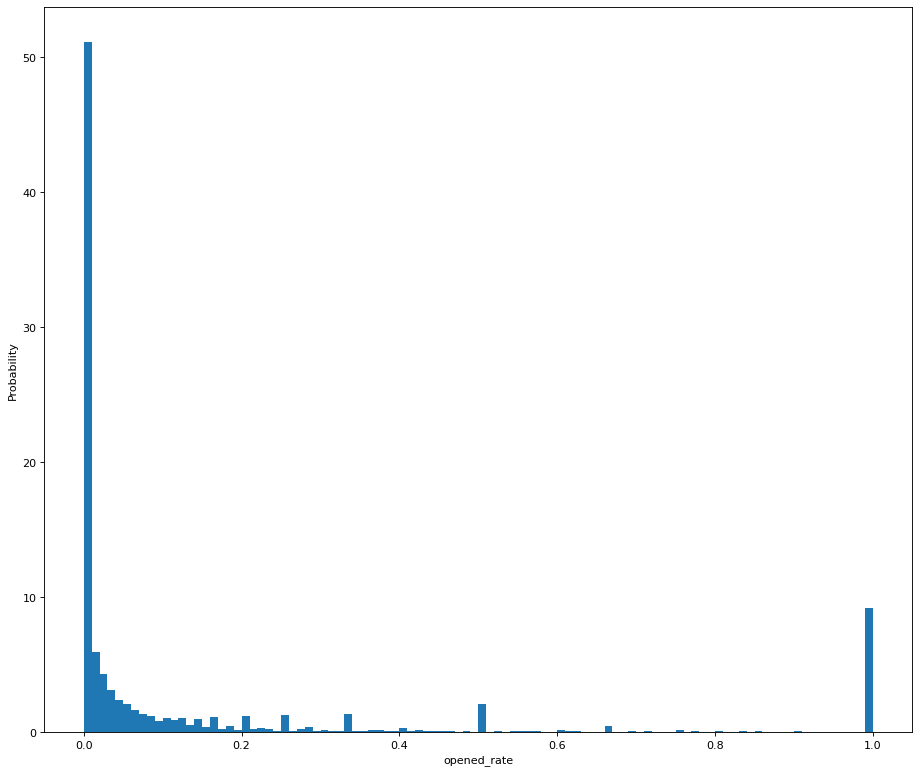

In [18]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

x=gpbyuser2.opened_rate

figure(figsize=(14, 12), dpi=80)
plt.hist(x, density=True, bins=100)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('opened_rate');

In [19]:
gpbyuser_dismissers= gpbyuser2.loc[gpbyuser2['opened_rate']== 0 ]
gpbyuser_dismissers

,area_of_effect_coordinates_latitude,area_of_effect_coordinates_longitude,agency_GewRJAw5tUmC4Ku4AX1-SQ,agency_GtvOEQAFZ0GtU6u4AXwvPg,agency_HE59N3RXM0q5vKu4AXlQZg,agency_JUR9bFXmVkWDHqu4AXaY0g,agency_JfA8Bw8Zp024Kqu4AXiSpQ,agency_MgUq5b9mOEunx6u4AXt_BA,agency_NuuRQ2I1Q0a50Kv-AVKlLA,agency_V2AIQQKgmUO3VazvAOA-Cw,agency_jLjibFoim0iwWau4AWoEdQ,agency_pky7jovXYkaw-awAAMrQ3g,agency_zCy9zG00HEqGeKu4AWZYNQ,notif_viewed_ontime,opened,count,opened_rate,ontime_activity_rate
user_id,,,,,,,,,,,,,,,,,,
00087,-1684.767232,330.804900,0.0,8.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,17.0,14,0,17,0.0,0.823529
00117,0.000000,0.000000,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0,4,0.0,0.750000
001e1,-1686.475347,328.643503,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,16,0,17,0.0,0.941176
002f1,-297.426877,58.184144,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,5,0.0,0.000000
002fa,-297.701659,58.497048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0,0,3,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffd86,-693.858813,137.385153,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,12,0,22,0.0,0.545455
ffedf,0.000000,0.000000,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0,4,0.0,1.000000
fff2a,-17638.600783,3458.458357,0.0,144.0,0.0,136.0,3.0,0.0,19.0,0.0,0.0,0.0,176.0,248,0,302,0.0,0.821192


In [20]:
gpbyuser_openers= gpbyuser2.loc[gpbyuser2['opened_rate']== 1]
gpbyuser_openers

,area_of_effect_coordinates_latitude,area_of_effect_coordinates_longitude,agency_GewRJAw5tUmC4Ku4AX1-SQ,agency_GtvOEQAFZ0GtU6u4AXwvPg,agency_HE59N3RXM0q5vKu4AXlQZg,agency_JUR9bFXmVkWDHqu4AXaY0g,agency_JfA8Bw8Zp024Kqu4AXiSpQ,agency_MgUq5b9mOEunx6u4AXt_BA,agency_NuuRQ2I1Q0a50Kv-AVKlLA,agency_V2AIQQKgmUO3VazvAOA-Cw,agency_jLjibFoim0iwWau4AWoEdQ,agency_pky7jovXYkaw-awAAMrQ3g,agency_zCy9zG00HEqGeKu4AWZYNQ,notif_viewed_ontime,opened,count,opened_rate,ontime_activity_rate
user_id,,,,,,,,,,,,,,,,,,
00573,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1.0,1.00
0072a,-198.225494,38.964150,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,3,4,4,1.0,0.75
00de8,-99.128561,19.481313,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3,3,3,1.0,1.00
00e96,-198.414337,38.854998,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2,2,2,1.0,1.00
00eae,0.000000,0.000000,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2,2,1.0,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff654,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1.0,1.00
ff900,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1.0,1.00
ffb6e,-297.093995,58.240704,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3,3,3,1.0,1.00


In [52]:
gpbyuser_openers['count'].sort_values(by='count').value_counts()

TypeError: sort_values() got an unexpected keyword argument 'by'

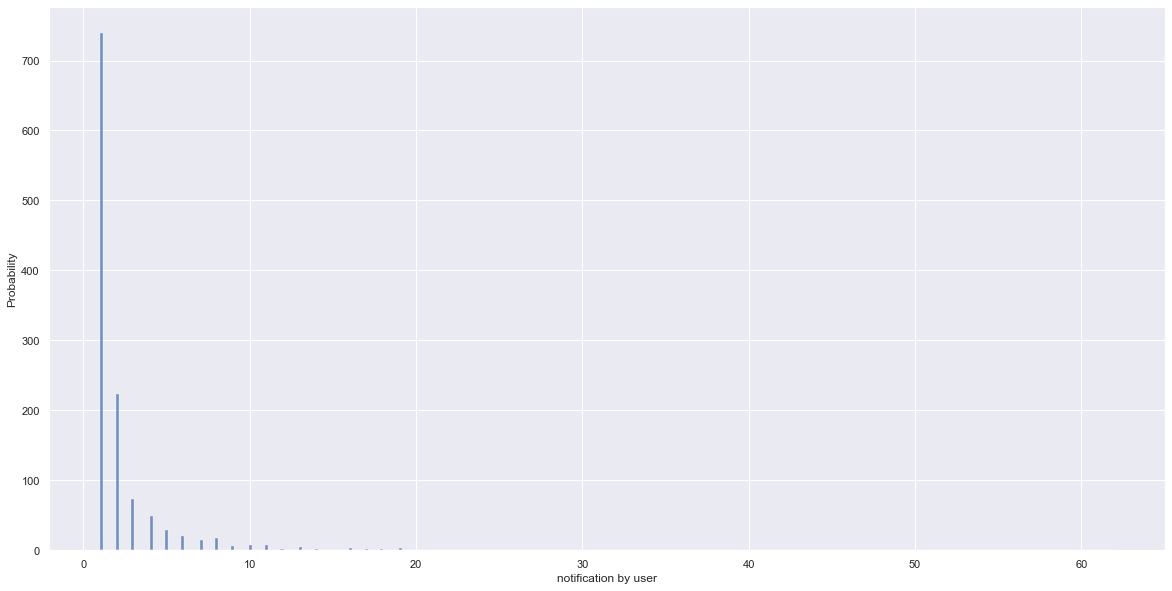

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
%matplotlib inline

x=gpbyuser_openers['count']

sns.set(rc={'figure.figsize':(20,10)})
sns.histplot(x)
plt.ylabel('Probability')
plt.xlabel('notification by user');

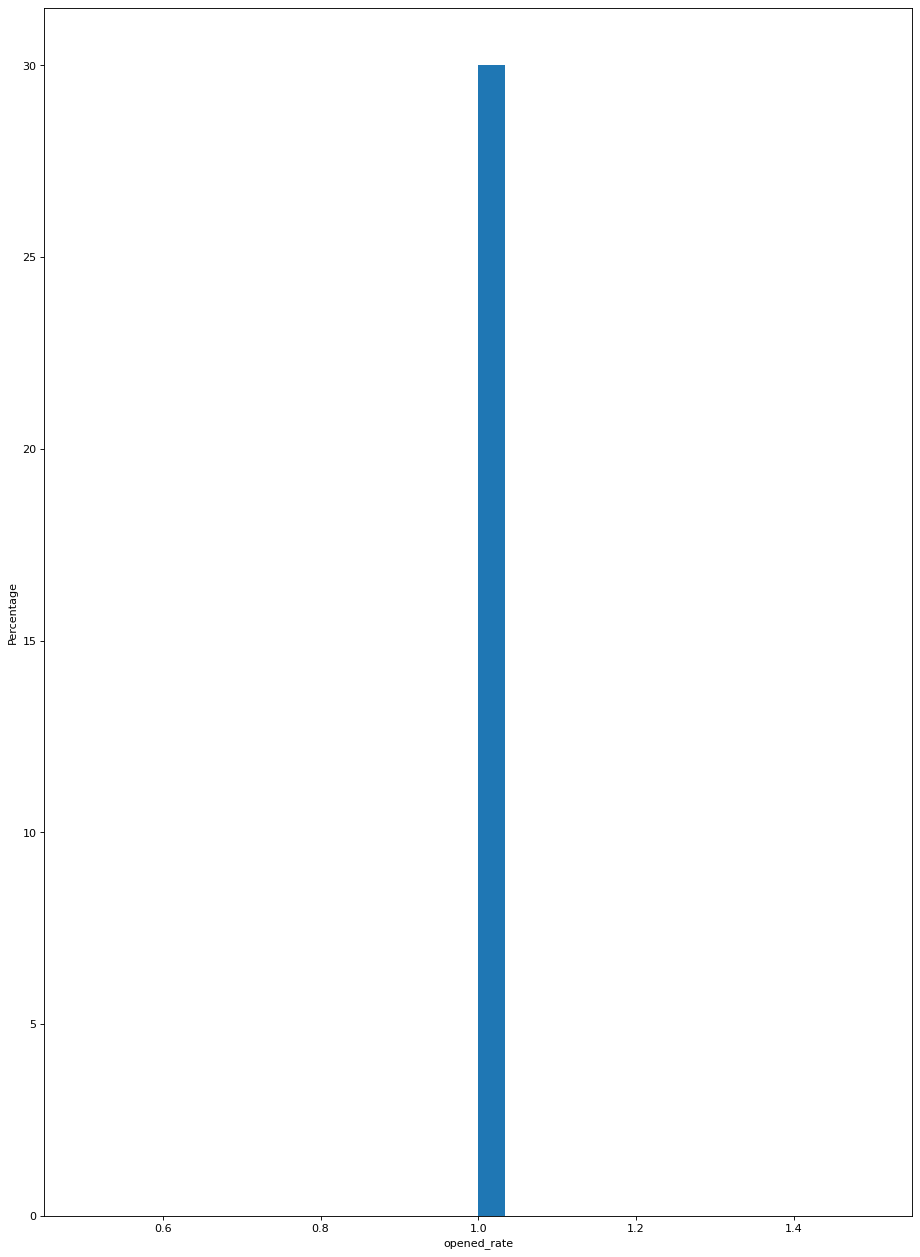

In [26]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

x=gpbyuser_openers.opened_rate

figure(figsize=(14, 20), dpi=80)
plt.hist(x, density=True, bins=30)  # density=False would make counts
plt.ylabel('Percentage')
plt.xlabel('opened_rate');

In [22]:
gpbyusera= active_df.groupby( by= ['user_id','document_id', 'description','cause', 'effect'])
#gpbyincident= export_df.groupby( by= ['document_id', 'description','cause', 'effect'])
gpbyusera2=gpbyusera.sum()
gpbyusera2['count'] = gpbyusera.size()
gpbyusera2['opened_rate'] = gpbyusera2['opened']/gpbyusera2['count']
gpbyusera2

e51 ⏳ ¡Changos! Hay retrasos por servicios de emerg... EmergencyServices Delays                                         0.0   
        -MQrFDklHqT8Kl6C98bf ⏳ ¡Ora! Hay retrasos por accidente vehicular en... VehicularAccident Delays                                         0.0   
...                                                                                                                                              ...   
fff82   -M_LxQlslPTVF2cgPtgA ✋ ¡Achis achis! Hay cierre de circulación por m... Demonstration     CirculationShutdown                            0.0   
        -M__Es1Mi_DXZc7C8kuU ⏳ ¡Chin! Retrasos por percance vehicular en la ... VehicularAccident Delays                                         0.0   
fffef   -MX-VAzPZMkEtJZ9qXgc ⏳ ¡Ya te la sabes! Usuarios reportan retrasos y... Incident          SecuritySpeed                                  0.0   
        -MX2C0MZbZnuVd3z3ByL ⏳ ¡Pon tu rola favorita y relájate! Usuarios in... Incident          SecuritySpeed                                  0.0   
        -MXlm7WGUblRTIJ3eVRB ⏳ ¡No de nuevo! Usuarios informan sobre retraso... Incident          SecuritySpeed                                  0.0   

                                                                                                                       agency_MgUq5b9mOEunx6u4AXt_BA  \
user_id document_id          description                                        cause             effect                                               
00087   -MQXXSmpbOh4k2FoUWLx ⏳ ¡Híjole! Hay retrasos por accidente vehicular... VehicularAccident Delays                                         0.0   
        -MQXz-FFSiWIe8BSujtY ⏳ ¡Ponte trucha! Hay retrasos por accidente veh... VehicularAccident Delays                                         0.0   
        -MQmIRBc4Qv0_t3s-qbw ⏳ ¡Tómalo en cuenta! Hay retrasos por accidente... VehicularAccident Delays                                         0.0   
        -MQmtcr2MNLKWPIafe51 ⏳ ¡Changos! Hay retrasos por servicios de emerg... EmergencyServices Delays                                         0.0   
        -MQrFDklHqT8Kl6C98bf ⏳ ¡Ora! Hay retrasos por accidente vehicular en... VehicularAccident Delays                                         0.0   
...                                                                                                                                              ...   
fff82   -M_LxQlslPTVF2cgPtgA ✋ ¡Achis achis! Hay cierre de circulación por m... Demonstration     CirculationShutdown                            0.0   
        -M__Es1Mi_DXZc7C8kuU ⏳ ¡Chin! Retrasos por percance vehicular en la ... VehicularAccident Delays                                         0.0   
fffef   -MX-VAzPZMkEtJZ9qXgc ⏳ ¡Ya te la sabes! Usuarios reportan retrasos y... Incident          SecuritySpeed                                  0.0   
        -MX2C0MZbZnuVd3z3ByL ⏳ ¡Pon tu rola favorita y relájate! Usuarios in... Incident          SecuritySpeed                                  0.0   
        -MXlm7WGUblRTIJ3eVRB ⏳ ¡No de nuevo! Usuarios informan sobre retraso... Incident          SecuritySpeed                                  0.0   

                                                                                                                       agency_NuuRQ2I1Q0a50Kv-AVKlLA  \
user_id document_id          description                                        cause             effect                                               
00087   -MQXXSmpbOh4k2FoUWLx ⏳ ¡Híjole! Hay retrasos por accidente vehicular... VehicularAccident Delays                                         0.0   
        -MQXz-FFSiWIe8BSujtY ⏳ ¡Ponte trucha! Hay retrasos por accidente veh... VehicularAccident Delays                                         0.0   
        -MQmIRBc4Qv0_t3s-qbw ⏳ ¡Tómalo en cuenta! Hay retrasos por accidente... VehicularAccident Delays                                         0.0   
        -MQmtcr2MNLKWPIafe51 ⏳ ¡Changos! Hay retrasos por servicios de 